<a href="https://colab.research.google.com/github/JoDeMiro/DeepLearningIntroduction/blob/main/07_LSTM_with_Synthetic_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Leírás

Itt a Keras API LSTM osztályának a használatát vizsgálom meg idősoroson adatokon.

Konkrét tervem van azzal, hogy tőzsdei idősorokon mutatom be, mert ezeken azután be fogom tudni mutatni az egyváltozós modelhez képest elérhető javulást a becsült és a valós érték között.

Ráadásul ez átmenetet fog képezni az egyváltozós modellből a töbválltozós modell irányába.

In [44]:
# !pip install --upgrade pandas
# !pip install --upgrade pandas-datareader

In [154]:
import os
import glob
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

from IPython.display import HTML
from base64 import b64encode

plt.style.use('fivethirtyeight')

# Generate synthetic data

Mondjuk az egyszerűség kedvéért legyen a kedvencem.

In [46]:
x = np.arange(0, 600, 1)

y = np.sin(x/180) + np.sin(x/60)

x = x.reshape(-1,1)
y = y

# Vizualizáció

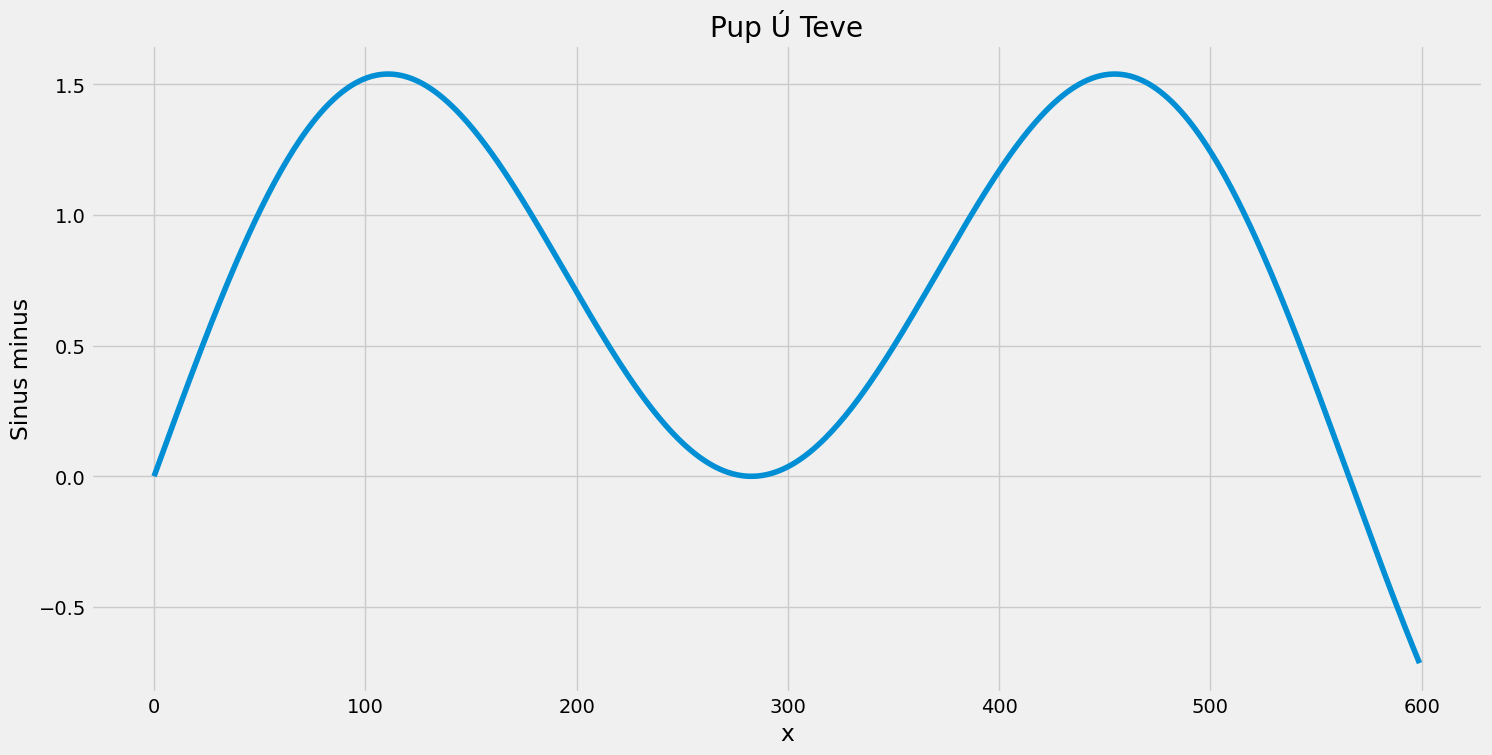

In [47]:
plt.figure(figsize=(16,8))
plt.title('Pup Ú Teve')
plt.plot(y)
plt.xlabel('x')
plt.ylabel('Sinus minus')
plt.show()

## Vágjuk ketté az idősort egy ponton tanuló és teszt adatokra

In [48]:
training_data_len = math.ceil(len(y) * 0.8)

training_data_len

480

## Mit akarunk becsülni mivel?

Csak halkan jegyzem meg, hogy itt egy idősort becsülök saját magával, vagyis a múltbeli adataival. Ugyhogy a konvencionális elnevezések úgy mint X_train, y_train egy kicsit félrevezetőek lehetnek. Itt ugyanis egy adatsor van amiből képezzük magát a bemeneti változókat, mint a kimeneti változót.

## Normalizáljuk az adatokat - transzformáljuk [0, 1] intervallumra

A tipikus hiba amit el lehet rontani, hogy a train adatokat is normalizálom, de most legyen így itt most nem ez a lényeg.

In [49]:
X_scaler = MinMaxScaler(feature_range=(0,1))
y_scaler = MinMaxScaler(feature_range=(0,1))

In [50]:
X_scaled = X_scaler.fit_transform(y.reshape(-1,1))
y_scaled = y_scaler.fit_transform(y.reshape(-1,1))

In [51]:
X_train = X_scaled[0:training_data_len, :]
y_train = y_scaled[0:training_data_len, :]

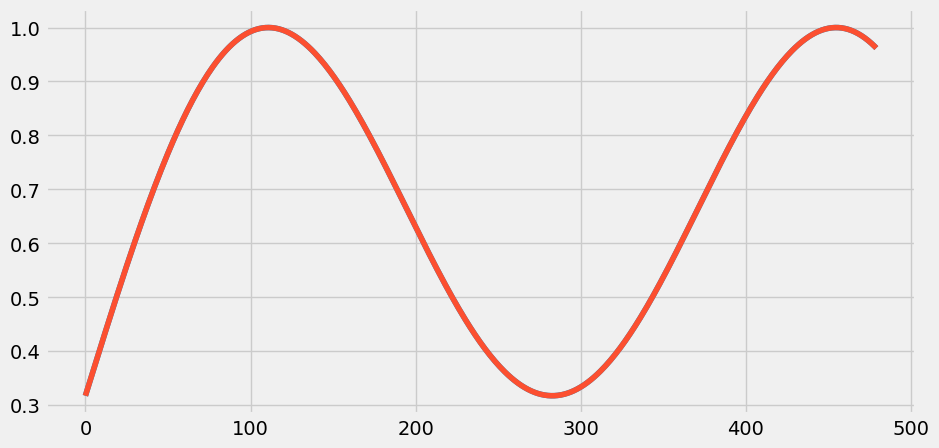

In [52]:
plt.figure(figsize=(10, 5))
plt.plot(X_train)
plt.plot(y_train)
plt.show()

## Csináljunk idő ablakokat

Magyarul olyan vektorokat amelyek tartalmazzák az idősor múltbeli értékét.


```
for i in range(window_size, len(train_data)):
  x_train.append(train_data[i-window_size:i, 0])
  y_train.append(train_data[i,0])
```



```
# Érdemes megfigyelni, y-t i-vel indexelem,
# x-et viszont i-ig,
#
# ezért gyakorlatilag t+1 relációt fogok becsülni,
# window_size hosszú vektorral.
```





In [53]:
X_training = []
y_training = []

window_size = 60

for i in range(window_size, len(X_train)):
  X_training.append(X_train[i-window_size:i, 0])
  y_training.append(X_train[i,0])

In [54]:
print(type(X_training))
print(type(X_training[1]))
print(X_training[1].shape)
print(X_training[1])

<class 'list'>
<class 'numpy.ndarray'>
(60,)
[0.32700809 0.3368617  0.34671106 0.35655403 0.36638849 0.37621231
 0.38602338 0.39581958 0.40559879 0.4153589  0.42509782 0.43481344
 0.44450368 0.45416644 0.46379965 0.47340124 0.48296916 0.49250134
 0.50199574 0.51145034 0.52086311 0.53023205 0.53955515 0.54883042
 0.5580559  0.56722963 0.57634965 0.58541404 0.59442088 0.60336827
 0.61225433 0.62107718 0.62983498 0.63852588 0.64714808 0.65569978
 0.6641792  0.67258457 0.68091416 0.68916625 0.69733914 0.70543115
 0.71344063 0.72136595 0.72920549 0.73695767 0.74462092 0.7521937
 0.7596745  0.76706182 0.7743542  0.7815502  0.78864839 0.7956474
 0.80254586 0.80934244 0.81603582 0.82262472 0.8291079  0.83548413]


In [55]:
print(type(y_training))
print(type(y_training[1]))
print(y_training[0].shape)
print(y_training[0])
print(y_training[1])

<class 'list'>
<class 'numpy.float64'>
()
0.835484131871363
0.8417522133999585


## Alakítsuk át az x_train és y_train listákat NumPy tömbökké

In [56]:
X_training, y_training = np.array(X_training), np.array(y_training)

print(X_training.shape)
print(y_training.shape)

(420, 60)
(420,)


## By the way - hogy is néz ez ki?

In [57]:
print(X_training[-1])
print(y_training[-1])
print(y_training[-2])
print(y_training[-3])

[0.92533219 0.92924821 0.9330734  0.93680627 0.94044535 0.94398921
 0.94743644 0.95078565 0.95403548 0.95718457 0.96023164 0.96317537
 0.96601453 0.96874786 0.97137417 0.97389228 0.97630103 0.9785993
 0.980786   0.98286005 0.98482043 0.98666613 0.98839616 0.99000958
 0.99150547 0.99288295 0.99414115 0.99527925 0.99629647 0.99719202
 0.99796519 0.99861528 0.99914161 0.99954355 0.99982051 0.9999719
 0.99999721 0.99989591 0.99966754 0.99931167 0.99882789 0.99821583
 0.99747516 0.99660557 0.9956068  0.99447861 0.9932208  0.99183321
 0.9903157  0.98866817 0.98689058 0.98498287 0.98294507 0.98077722
 0.97847938 0.97605166 0.97349422 0.97080722 0.96799089 0.96504546]
0.961971222337937
0.9650454611226844
0.967990888402567


## Reshape the data

Erre a lépésre azért van szükség mert a Keras model egy picit más formában várja majd az adatokat.

In [58]:
X_training_reshaped = np.reshape(X_training, (X_training.shape[0], X_training.shape[1], 1))

X_training_reshaped.shape

(420, 60, 1)

In [59]:
print(X_training_reshaped[1][1:10])

[[0.3368617 ]
 [0.34671106]
 [0.35655403]
 [0.36638849]
 [0.37621231]
 [0.38602338]
 [0.39581958]
 [0.40559879]
 [0.4153589 ]]


# Build the LSTM model

Keep it simple - kezdjük valmai egyszerűvel.

In [60]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape = (X_training_reshaped.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(25))
model.add(Dense(1))

## Compile the model

In [61]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [62]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense_3 (Dense)             (None, 25)                1275      
                                                                 
 dense_4 (Dense)             (None, 25)                650       
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 32,551
Trainable params: 32,551
Non-trainable params: 0
_________________________________________________________________


## Visualise the arch. of mod.

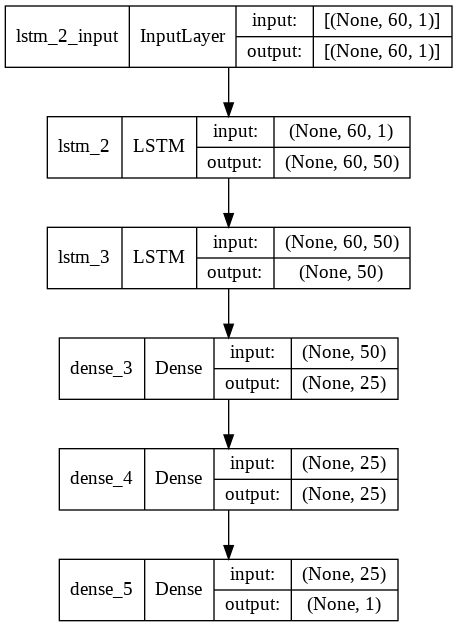

In [63]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot1.png', show_shapes=True, show_layer_names=True)

## Train the model

In [125]:
# history = model.fit(X_training_reshaped, y_training, batch_size=100, epochs=10)

history = model.fit(X_training_reshaped, y_training, batch_size=y.shape[0], epochs=20)

Epoch 1/20
1/1 [==============================] - 0s 308ms/step - loss: 0.0012
Epoch 2/20
1/1 [==============================] - 0s 324ms/step - loss: 0.0011
Epoch 3/20
1/1 [==============================] - 0s 324ms/step - loss: 0.0011
Epoch 4/20
1/1 [==============================] - 0s 320ms/step - loss: 0.0011
Epoch 5/20
1/1 [==============================] - 0s 305ms/step - loss: 0.0011
Epoch 6/20
1/1 [==============================] - 0s 318ms/step - loss: 0.0011
Epoch 7/20
1/1 [==============================] - 0s 319ms/step - loss: 0.0011
Epoch 8/20
1/1 [==============================] - 0s 318ms/step - loss: 0.0011
Epoch 9/20
1/1 [==============================] - 0s 313ms/step - loss: 0.0011
Epoch 10/20
1/1 [==============================] - 0s 323ms/step - loss: 0.0011
Epoch 11/20
1/1 [==============================] - 0s 308ms/step - loss: 0.0010
Epoch 12/20
1/1 [==============================] - 0s 310ms/step - loss: 0.0010
Epoch 13/20
1/1 [==============================] 

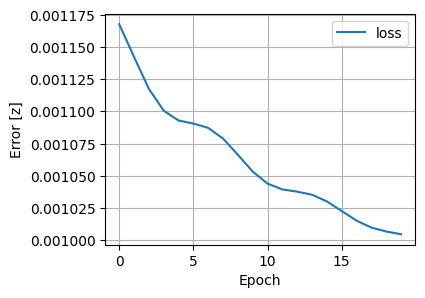

In [126]:
def plot_loss(history):
  plt.figure(figsize=(4, 3))
  plt.plot(history.history['loss'], label='loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [z]')
  plt.legend()
  plt.grid(True)

plt.style.use('default')
plot_loss(history)

## Create the testing data set

Ezt korábban is megcsinálhattam volna, de jobban tetszik, hogy elöbb a modelt tanítottam fel.

```
# Nem ám elfelejteni, hogy már [0, 1] intervallumra skáláztam az adatokat. Ami hiba.
```



In [127]:
X_test = X_scaled[training_data_len - window_size: , :]

print(window_size)
print(type(X_test))
print(X_test.shape)

60
<class 'numpy.ndarray'>
(180, 1)


In [128]:
X_testing = []
y_testing = X_scaled[training_data_len: , :]

for i in range(window_size, len(X_test)):
  X_testing.append(X_test[i-window_size:i, 0])

In [129]:
print(type(y_test))
print(y_testing.shape)
print(y_testing[1])

print(type(X_testing))
print(X_testing[1].shape)
print(X_testing[1])

<class 'numpy.ndarray'>
(120, 1)
[0.95543761]
<class 'list'>
(60,)
[0.9330734  0.93680627 0.94044535 0.94398921 0.94743644 0.95078565
 0.95403548 0.95718457 0.96023164 0.96317537 0.96601453 0.96874786
 0.97137417 0.97389228 0.97630103 0.9785993  0.980786   0.98286005
 0.98482043 0.98666613 0.98839616 0.99000958 0.99150547 0.99288295
 0.99414115 0.99527925 0.99629647 0.99719202 0.99796519 0.99861528
 0.99914161 0.99954355 0.99982051 0.9999719  0.99999721 0.99989591
 0.99966754 0.99931167 0.99882789 0.99821583 0.99747516 0.99660557
 0.9956068  0.99447861 0.9932208  0.99183321 0.9903157  0.98866817
 0.98689058 0.98498287 0.98294507 0.98077722 0.97847938 0.97605166
 0.97349422 0.97080722 0.96799089 0.96504546 0.96197122 0.95876849]


## List -> Numpy

In [130]:
X_testing = np.array(X_testing)

## Reshape the data

In [131]:
X_testing = np.reshape(X_testing, (X_testing.shape[0], X_testing.shape[1], 1))

In [132]:
print(type(X_testing))
print(X_testing.shape)
print(X_testing[1][1:5])

<class 'numpy.ndarray'>
(120, 60, 1)
[[0.93680627]
 [0.94044535]
 [0.94398921]
 [0.94743644]]


## Get the models predicted price values

In [133]:
predictions = model.predict(X_testing)

In [134]:
print(predictions.shape)
print(predictions[0])

(120, 1)
[0.98035526]


## Invert the scaled values to the original

In [135]:
predictions_inverted = y_scaler.inverse_transform(predictions)

In [136]:
predictions_inverted[0]

array([1.495302], dtype=float32)

## Measure the error of the prediction

In [137]:
root_mean_square_error = np.sqrt( np.mean( predictions_inverted - y_testing )**2 )

In [138]:
root_mean_square_error

0.09671347985921637

In [139]:
pearsons_correlation = np.corrcoef(predictions_inverted.flatten(), y_testing.flatten())

In [140]:
pearsons_correlation[0,1]

0.9999018150989374

## Create a new arrays

In [142]:
train = np.zeros(x.size)
train[:training_data_len] = y[:training_data_len]

valid = np.zeros(x.size)
valid[training_data_len:] = y[training_data_len:]

# predicted = np.zeros(x.size)
predicted = np.empty(x.size)
predicted[training_data_len:] = predictions_inverted.flatten()

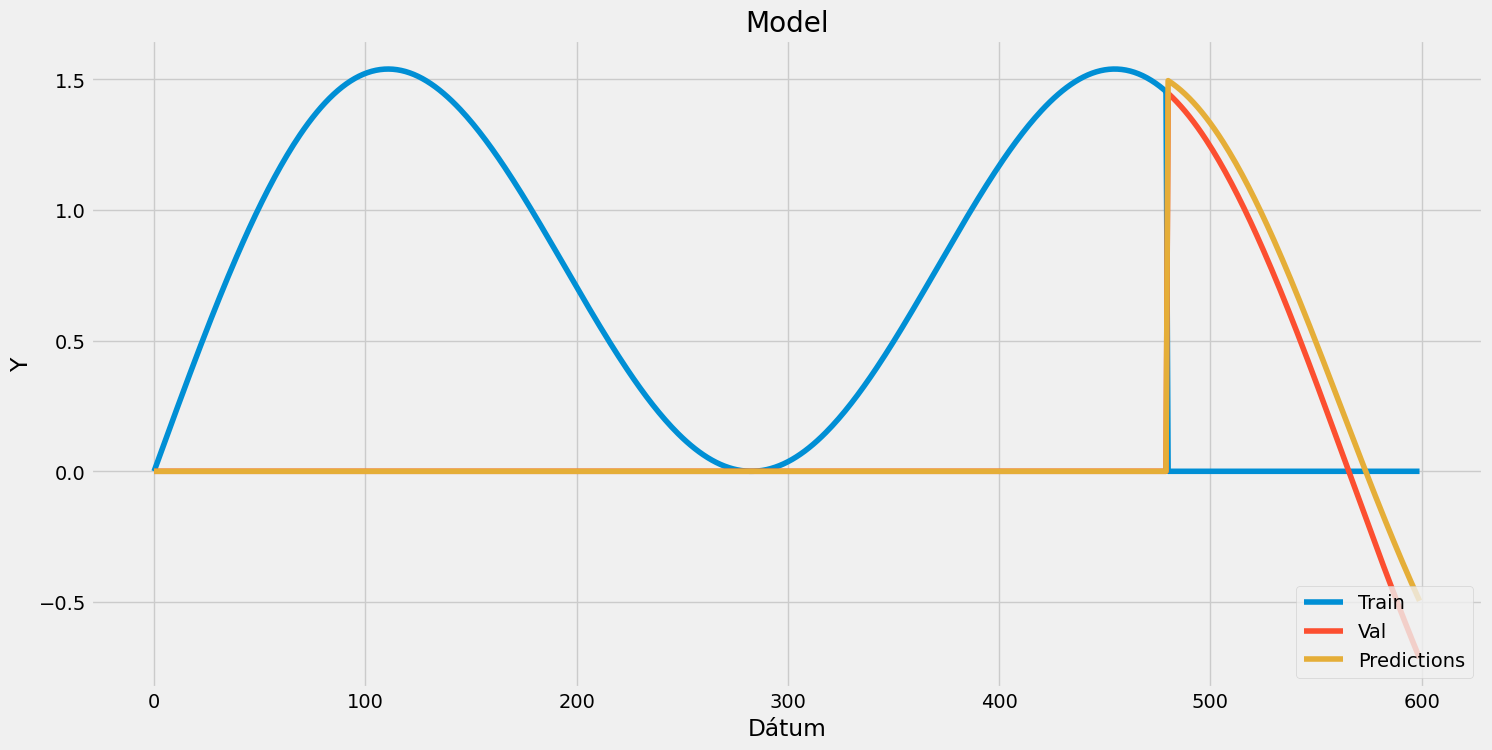

In [143]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Dátum')
plt.ylabel('Y')
plt.plot(train)
plt.plot(valid)
plt.plot(predicted)
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')

plt.show()

## Nézzük, hogy alakul a becslés tanulás közben

In [158]:
import tensorflow as tf
tf.get_logger().setLevel('INFO')

In [168]:
! rm *.png

model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape = (X_training_reshaped.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# ---------
X_test = X_scaled[training_data_len - window_size: , :]
X_testing = []
y_testing = X_scaled[training_data_len: , :]

for i in range(window_size, len(X_test)):
  X_testing.append(X_test[i-window_size:i, 0])

X_testing = np.array(X_testing)
X_testing = np.reshape(X_testing, (X_testing.shape[0], X_testing.shape[1], 1))

train = np.zeros(x.size)
train[:training_data_len] = y[:training_data_len]

valid = np.zeros(x.size)
valid[training_data_len:] = y[training_data_len:]

# ---------
max_epoch = 30
epoch_per_iter = 1
batch_size = y.shape[0]
batch_size = 32

for i in range(max_epoch):

  model.fit(X_training_reshaped, y_training, batch_size=batch_size, epochs=epoch_per_iter)

  predictions = model.predict(X_testing)
  predictions_inverted = y_scaler.inverse_transform(predictions)

  predicted = np.zeros(x.size)
  predicted[training_data_len:] = predictions_inverted.flatten()

  plt.style.use('fivethirtyeight')
  plt.style.use('default')
  plt.figure(figsize=(7, 4))
  plt.title('Model')
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.plot(train)
  plt.plot(valid)
  plt.plot(predicted)
  plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
  plt.savefig('image{0:03}'.format(i)+'.png')
  # plt.show()
  plt.close()

14/14 [==============================] - 1s 58ms/step - loss: 1.4158e-05


In [169]:

def create_animated_mp4(filter = 'image*.png', prefix = 'animated_', framerate = 10):
  output = prefix + filter[0:filter.find('*')] + '.mp4'
  os.system('rm ' + output)
  if( len(glob.glob(filter)) > 0 ):
    os.system('ffmpeg -r ' + str(framerate) + ' -pattern_type glob -i "' + filter + '" -vcodec libx264 -crf 25 -pix_fmt yuv420p ' + output)

    print('ok')

  else:
    print('skipped')
    pass


In [170]:
create_animated_mp4('image*.png', 'animated_', framerate=10)

ok


In [171]:
mp4 = open('animated_image.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML("""
<video width=432 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)



```
# JoDeMiro
```

